In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from joblib import Parallel, delayed
import pickle
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
from Bio import Entrez
from collections import defaultdict
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
PWD = Path().cwd()
DATA = Path("../data")
IPS = DATA / "rnaseq_res_ips"
FIBRO = DATA / "rnaseq_res_fibro"
HIMORNA = DATA / "himorna_peaks"
FANTOM = DATA / "fantom_cat"
PREPROCESSING = Path("../preprocessing")
HIMORNA_INDEX = PREPROCESSING / "himorna_index"
IPS_INDEX = PREPROCESSING / "ips_deg_index"
MATRICES = PREPROCESSING / "matrices"
FISHER = PREPROCESSING / "fisher_exact_test"

## fantom fibroblast deg

In [5]:
to_fibro = FIBRO / "DESeq2_genes_ASO_signif.tsv"
fibro_expr = pd.read_csv(to_fibro, sep="\t")
fibro_expr.head()

,geneID,geneSymbol,ASO_G0268895_01,ASO_G0268895_03,ASO_G0205485_01,ASO_G0205485_03,ASO_G0231185_02,ASO_G0231185_03,ASO_G0231312_02,ASO_G0231312_04,...,ASO_G0247240_AD_05,ASO_G0247240_AD_06,ASO_G0180769_03,ASO_G0180769_08,ASO_G0180769_AD_03,ASO_G0234420_01,ASO_G0230844_01,ASO_G0230844_AD_06,ASO_G0269293_01,ASO_G0269293_AD_10
0,ENSG00000200169,RNU5D-1,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ENSG00000138675,FGF5,-1,0,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ENSG00000252521,RNU5D-2P,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ENSG00000268895,A1BG-AS1,-1,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CATG00000098831,CATG00000098831.1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
fibro_expr.shape

(16989, 342)

In [7]:
noDeg_aso = fibro_expr[2:].sum().isin([0]).sum() / fibro_expr[2:].columns.shape[0] * 100# % ASO в фиброблстах, не имеющих ни одного DEG
print(f"{np.round(noDeg_aso, 2)} %")

15.5 %


In [8]:
to_fibro_aso = FIBRO / "ASO_names.info"
fibro_aso = pd.read_csv(to_fibro_aso, sep="\t")
fibro_aso.head()

,aso_id,aso_id_short,prmtrID,prmtrName,trnscptID,trnscptName,trnscptType,geneID,geneName,geneType
0,ASO_C0000830_02,C0000830,CUFT00000000830.T0,chr1_50977446_50977745_+,p012@CDKN2C,CUFT00000000830.T0,__na,ENSG00000123080,CDKN2C,protein_coding
1,ASO_C0000830_08,C0000830,CUFT00000000830.T0,chr1_50977446_50977745_+,p012@CDKN2C,CUFT00000000830.T0,__na,ENSG00000123080,CDKN2C,protein_coding
2,ASO_C0008202_01,C0008202,CUFT00000008202.T0,chr4_183350680_183350979_-,p003@CLDN22,CUFT00000008202.T0,__na,ENSG00000177300,CLDN22,protein_coding
3,ASO_C0008202_02,C0008202,CUFT00000008202.T0,chr4_183350680_183350979_-,p003@CLDN22,CUFT00000008202.T0,__na,ENSG00000177300,CLDN22,protein_coding
4,ASO_C0008202_04,C0008202,CUFT00000008202.T0,chr4_183350680_183350979_-,p003@CLDN22,CUFT00000008202.T0,__na,ENSG00000177300,CLDN22,protein_coding


In [9]:
aso_gene_dict_fibro = {}
for geneName, subdf in fibro_aso.groupby(by="geneName"):
    for aso in subdf["aso_id"]:
        aso_gene_dict_fibro[aso] = geneName

In [14]:
aso_gene_dict_fibro

{'ASO_G0268895_01': 'A1BG-AS1',
 'ASO_G0268895_03': 'A1BG-AS1',
 'ASO_G0205485_01': 'AC004980.7',
 'ASO_G0205485_03': 'AC004980.7',
 'ASO_G0231185_02': 'AC005592.2',
 'ASO_G0231185_03': 'AC005592.2',
 'ASO_G0231312_02': 'AC007246.3',
 'ASO_G0231312_04': 'AC007246.3',
 'ASO_G0229647_06': 'AC007879.7',
 'ASO_G0229647_AD_09': 'AC007879.7',
 'ASO_G0267751_AD_02': 'AC009005.2',
 'ASO_G0223960_08': 'AC009948.5',
 'ASO_G0223960_AD_10': 'AC009948.5',
 'ASO_G0234327_01': 'AC012146.7',
 'ASO_G0234327_07': 'AC012146.7',
 'ASO_G0272888_04': 'AC013394.2',
 'ASO_G0272888_AD_07': 'AC013394.2',
 'ASO_G0272888_AD_10': 'AC013394.2',
 'ASO_G0212978_01': 'AC016747.3',
 'ASO_G0212978_02': 'AC016747.3',
 'ASO_G0212978_03': 'AC016747.3',
 'ASO_G0212978_04': 'AC016747.3',
 'ASO_G0163364_04': 'AC017048.3',
 'ASO_G0163364_06': 'AC017048.3',
 'ASO_G0163364_AD_01': 'AC017048.3',
 'ASO_G0224577_01': 'AC017048.4',
 'ASO_G0224577_02': 'AC017048.4',
 'ASO_G0224577_05': 'AC017048.4',
 'ASO_G0224577_AD_05': 'AC017048.4

In [54]:
len(aso_gene_dict_fibro)

350

In [10]:
fibro_aso['aso_id'].unique().shape

(350,)

In [11]:
aso = "R0019755_01"
[i.name.split("-")[0] for i in IPS_INDEX.glob(f'*/*{aso}*.tsv.gz')][0]

'CATG00000014483'

In [12]:
aso_gene_dict_ips = {i.name.split("-")[1]:i.name.split("-")[0] for i in IPS_INDEX.glob(f'*/*.tsv.gz')}

In [13]:
aso_gene_dict_ips

{'G0247572_08': 'ENSG00000247572',
 'G0261366_02': 'ENSG00000261366',
 'G0261366_04': 'ENSG00000261366',
 'G0260267_06': 'ENSG00000260267',
 'G0260267_02': 'ENSG00000260267',
 'G0266916_04': 'ENSG00000266916',
 'G0235437_07': 'ENSG00000235437',
 'G0235437_06': 'ENSG00000235437',
 'G0225489_01': 'ENSG00000225489',
 'R0040849_06': 'CATG00000042742',
 'R0040849_07': 'CATG00000042742',
 'G0250337_05': 'ENSG00000250337',
 'G0250337_03': 'ENSG00000250337',
 'G0250337_06': 'ENSG00000250337',
 'R0080446_04': 'CATG00000109338',
 'G0233393_07': 'ENSG00000233393',
 'G0229852_AD_01': 'ENSG00000229852',
 'G0229852_01': 'ENSG00000229852',
 'G0251580_07': 'ENSG00000251580',
 'G0251580_01': 'ENSG00000251580',
 'G0246067_AD_09': 'ENSG00000246067',
 'G0246067_AD_04': 'ENSG00000246067',
 'G0223813_02': 'ENSG00000223813',
 'G0223813_01': 'ENSG00000223813',
 'G0230623_09': 'ENSG00000230623',
 'G0230623_02': 'ENSG00000230623',
 'G0230623_05': 'ENSG00000230623',
 'G0237976_03': 'ENSG00000237976',
 'G0237976_

In [55]:
len(aso_gene_dict_ips)

259

In [15]:
aso_gene_dict = {}
aso_gene_dict["fibro"] = aso_gene_dict_fibro
aso_gene_dict["ips"] = aso_gene_dict_ips

In [56]:
[len(aso_gene_dict[i]) for i in aso_gene_dict]

[350, 259]

In [53]:
for aso in fibro_expr.columns[2:]:
    if aso not in aso_gene_dict["fibro"]:
        print(aso)

ASO_C0012015_07
ASO_C0012015_AD_02
ASO_C0012015_AD_04
ASO_C0012015_AD_05
ASO_C014559_06
ASO_C013368_01
ASO_C013368_02


def deg_from_aso_fibro(aso):
    mask = fibro_expr[aso].apply(lambda x: False if x == 0 else True)
    return fibro_expr[mask]["geneID"]

def deg_from_aso_fibro(aso):
    mask = fibro_expr[aso] != 0
    return fibro_expr[mask]["geneID"]

In [17]:
def deg_from_aso_fibro(aso):
    mask = fibro_expr[aso] != 0
    return fibro_expr.loc[mask, "geneID"]

In [18]:
over10k_deg_aso = []
for aso in fibro_expr.columns[2:]:
    if len(deg_from_aso_fibro(aso)) > 6000:
        print(aso, len(deg_from_aso_fibro(aso)))
        over10k_deg_aso.append(aso)

ASO_G0260833_06 8642
ASO_G0267577_01 8298
ASO_G0246067_AD_06 7031
ASO_G0231187_02 7213
ASO_G0233396_07 6022


In [19]:
len(over10k_deg_aso)

5

In [59]:
list(combinations(over10k_deg_aso, 2))

[('ASO_G0260833_06', 'ASO_G0267577_01'),
 ('ASO_G0260833_06', 'ASO_G0246067_AD_06'),
 ('ASO_G0260833_06', 'ASO_G0231187_02'),
 ('ASO_G0260833_06', 'ASO_G0233396_07'),
 ('ASO_G0267577_01', 'ASO_G0246067_AD_06'),
 ('ASO_G0267577_01', 'ASO_G0231187_02'),
 ('ASO_G0267577_01', 'ASO_G0233396_07'),
 ('ASO_G0246067_AD_06', 'ASO_G0231187_02'),
 ('ASO_G0246067_AD_06', 'ASO_G0233396_07'),
 ('ASO_G0231187_02', 'ASO_G0233396_07')]

In [20]:
len(list(combinations(over10k_deg_aso, 2)))

10

In [21]:
%%time
deg_from_aso_fibro("ASO_G0231185_03")

CPU times: user 2.57 ms, sys: 0 ns, total: 2.57 ms
Wall time: 2.04 ms


1        ENSG00000138675
8        ENSG00000183098
11       ENSG00000149571
14       ENSG00000142892
28       ENSG00000162981
              ...       
15865    ENSG00000165695
15939    ENSG00000141294
15952    ENSG00000118898
15987    CATG00000106578
16085    ENSG00000224215
Name: geneID, Length: 844, dtype: object

In [22]:
deg_from_aso_fibro("ASO_G0231185_03")

1        ENSG00000138675
8        ENSG00000183098
11       ENSG00000149571
14       ENSG00000142892
28       ENSG00000162981
              ...       
15865    ENSG00000165695
15939    ENSG00000141294
15952    ENSG00000118898
15987    CATG00000106578
16085    ENSG00000224215
Name: geneID, Length: 844, dtype: object

In [23]:
def gini(aso_list, exp):
    rna = []
    results_gini_df = pd.DataFrame(columns=["gini_index"])
    pairs = list(combinations(aso_list, 2))
    #results_gini = {i:0 for i in pairs}
    related_aso = []
    for i, pair in enumerate(pairs):
        if pair[0] in aso_gene_dict[exp] and pair[1] in aso_gene_dict[exp]:
            if aso_gene_dict[exp][pair[0]] == aso_gene_dict[exp][pair[1]]:
                rna.append(aso_gene_dict[exp][pair[0]])
                related_aso.append(pair)
                if exp == "fibro":
                    deg_1 = np.asarray(deg_from_aso_fibro(pair[0]))
                    deg_2 = np.asarray(deg_from_aso_fibro(pair[1]))
                if exp == "ips":
                    deg_1 = np.asarray(deg_from_aso_ips(pair[0]))
                    deg_2 = np.asarray(deg_from_aso_ips(pair[1]))
                # Пересечение
                intersection = np.intersect1d(deg_1, deg_2)
                # Объединение
                union = np.union1d(deg_1, deg_2)
                try:
                    gini_index = intersection.shape[0] / union.shape[0]
                    number_of_union_genes = int(union.shape[0])
                except ZeroDivisionError:
                    gini_index = None
                results_gini_df.loc[i, "gini_index"] = gini_index
                results_gini_df.loc[i, "number_of_union_genes"] = number_of_union_genes
        
            results_gini_df["aso_pairs"] = related_aso
    return results_gini_df, len(np.unique(rna))

In [24]:
results_gini_df_fibro = gini(aso_list=fibro_expr.columns[2:], exp="fibro")

In [60]:
list(combinations(fibro_expr.columns[2:], 2))

[('ASO_G0268895_01', 'ASO_G0268895_03'),
 ('ASO_G0268895_01', 'ASO_G0205485_01'),
 ('ASO_G0268895_01', 'ASO_G0205485_03'),
 ('ASO_G0268895_01', 'ASO_G0231185_02'),
 ('ASO_G0268895_01', 'ASO_G0231185_03'),
 ('ASO_G0268895_01', 'ASO_G0231312_02'),
 ('ASO_G0268895_01', 'ASO_G0231312_04'),
 ('ASO_G0268895_01', 'ASO_G0229647_06'),
 ('ASO_G0268895_01', 'ASO_G0229647_AD_09'),
 ('ASO_G0268895_01', 'ASO_G0267751_AD_02'),
 ('ASO_G0268895_01', 'ASO_G0223960_08'),
 ('ASO_G0268895_01', 'ASO_G0223960_AD_10'),
 ('ASO_G0268895_01', 'ASO_G0234327_01'),
 ('ASO_G0268895_01', 'ASO_G0234327_07'),
 ('ASO_G0268895_01', 'ASO_G0272888_04'),
 ('ASO_G0268895_01', 'ASO_G0272888_AD_07'),
 ('ASO_G0268895_01', 'ASO_G0272888_AD_10'),
 ('ASO_G0268895_01', 'ASO_G0212978_01'),
 ('ASO_G0268895_01', 'ASO_G0212978_02'),
 ('ASO_G0268895_01', 'ASO_G0212978_03'),
 ('ASO_G0268895_01', 'ASO_G0212978_04'),
 ('ASO_G0268895_01', 'ASO_G0163364_04'),
 ('ASO_G0268895_01', 'ASO_G0163364_06'),
 ('ASO_G0268895_01', 'ASO_G0163364_AD_01')

In [65]:
results_gini_df_fibro[0]

,gini_index,number_of_union_genes,aso_pairs
0,0.079493,2843.0,"(ASO_G0268895_01, ASO_G0268895_03)"
677,0.002988,1004.0,"(ASO_G0205485_01, ASO_G0205485_03)"
1350,0.062831,1321.0,"(ASO_G0231185_02, ASO_G0231185_03)"
2019,0.002646,378.0,"(ASO_G0231312_02, ASO_G0231312_04)"
2684,0.0,64.0,"(ASO_G0229647_06, ASO_G0229647_AD_09)"
...,...,...,...
57602,0.0,7.0,"(ASO_G0180769_03, ASO_G0180769_08)"
57603,0.0,3.0,"(ASO_G0180769_03, ASO_G0180769_AD_03)"
57609,0.0,8.0,"(ASO_G0180769_08, ASO_G0180769_AD_03)"
57624,0.0,879.0,"(ASO_G0230844_01, ASO_G0230844_AD_06)"


## fantom ips deg

In [26]:
to_ips = IPS / "EdgeR.table.all.target.tsv.gz"
ips_expr = pd.read_csv(to_ips, sep="\t")
ips_expr.head()

,DEG.geneID,DEG.HGNC,EdgeR.log2FC,EdgeR.log2CPM,EdgeR.pvalue,EdgeR.FDR,EdgeR.Zscore,target.gapmerID,target.geneID,target.HGNC
0,CATG00000000155,CATG00000000155.1,0.257141,3.591144,0.550588,1.0,0.620927,G0234787_01,ENSG00000234787,LINC00458
1,CATG00000001164,CATG00000001164.1,0.706131,3.805757,0.044323,1.0,1.757448,G0234787_01,ENSG00000234787,LINC00458
2,CATG00000001318,CATG00000001318.1,-0.074655,4.766566,0.913694,1.0,0.052701,G0234787_01,ENSG00000234787,LINC00458
3,CATG00000002817,CATG00000002817.1,-0.201767,3.841792,0.716487,1.0,-0.414103,G0234787_01,ENSG00000234787,LINC00458
4,CATG00000003248,CATG00000003248.1,-0.155609,4.592817,0.650460,1.0,0.026003,G0234787_01,ENSG00000234787,LINC00458


In [27]:
ips_expr.shape

(3445156, 10)

In [28]:
ips_expr_filt = ips_expr[(((ips_expr["EdgeR.log2FC"] < 0.5) & (ips_expr["EdgeR.Zscore"] < -1.64)) | 
                                ((ips_expr["EdgeR.log2FC"] > 0.5) & (ips_expr["EdgeR.Zscore"] > 1.64))) & 
                                (ips_expr["EdgeR.FDR"] < 0.05)]
ips_expr_filt.reset_index(inplace=True, drop=True)
ips_expr_filt.head()       

,DEG.geneID,DEG.HGNC,EdgeR.log2FC,EdgeR.log2CPM,EdgeR.pvalue,EdgeR.FDR,EdgeR.Zscore,target.gapmerID,target.geneID,target.HGNC
0,ENSG00000205531,NAP1L4,-0.691972,7.349218,3.899614e-06,0.042455,-5.061144,G0234787_08,ENSG00000234787,LINC00458
1,ENSG00000089916,GPATCH2L,-1.041246,5.600935,3.913478e-05,0.043336,-3.953852,R0057746_03,CATG00000070943,CATG00000070943.1
2,ENSG00000099194,SCD,-0.635000,8.662415,2.054724e-07,0.000870,-2.709444,R0057746_03,CATG00000070943,CATG00000070943.1
3,ENSG00000113161,HMGCR,-0.912822,6.861125,1.601495e-05,0.029059,-3.682696,R0057746_03,CATG00000070943,CATG00000070943.1
4,ENSG00000128829,EIF2AK4,-0.887877,6.605389,2.397361e-07,0.000870,-4.709886,R0057746_03,CATG00000070943,CATG00000070943.1


In [29]:
ips_expr_filt.shape

(16294, 10)

In [30]:
ips_expr_filt["target.gapmerID"].unique()

array(['G0234787_08', 'R0057746_03', 'G0254635_01', 'G0253352_AD_01',
       'G0253352_02', 'G0267040_02', 'G0267040_08', 'G0228592_10',
       'R0016212_01', 'G0245571_AD_03', 'G0246067_AD_04', 'R0042263_02',
       'G0254635_08', 'G0229852_01', 'G0245571_03', 'G0237298_01',
       'R0016212_08', 'G0230590_AD_03', 'R0067169_07', 'G0230590_AD_02',
       'G0212978_03', 'G0246273_05', 'G0224597_02', 'G0234546_AD_09',
       'G0253352_AD_07', 'G0212978_04', 'R0038353_02', 'G0223546_01',
       'G0246067_AD_09', 'G0234546_AD_05', 'R0016212_06', 'R0067169_01',
       'G0237298_09', 'G0246273_AD_08', 'G0212978_06', 'G0241472_07',
       'G0228592_05', 'G0223546_09', 'R0042263_04', 'G0246273_01',
       'G0229852_AD_01', 'G0215447_03', 'G0228592_02', 'G0246273_02',
       'G0223546_05', 'G0253352_06', 'G0234546_AD_04', 'G0264164_04',
       'G0254635_10', 'G0231185_03', 'G0234171_09', 'G0253352_01',
       'G0224597_05', 'G0231185_09', 'C0020672_02', 'G0241472_04',
       'G0234546_02', 'G02

In [31]:
def deg_from_aso_ips(aso):
    to_deg = [i for i in IPS_INDEX.glob(f'*/*{aso}*.tsv.gz')][0]
    deg_gene_ids = np.asarray(pd.read_csv(to_deg, sep="\t", usecols=["DEG.geneID"])["DEG.geneID"])
    return deg_gene_ids

In [32]:
deg_from_aso_ips("G0188002_01")

array(['ENSG00000169223', 'ENSG00000188002'], dtype=object)

In [33]:
results_gini_df_ips = gini(aso_list=ips_expr_filt["target.gapmerID"].unique(), exp="ips")

In [34]:
results_gini_df_ips[1]

98

In [40]:
results_gini_df_ips[0].shape

(200, 3)

In [41]:
fibro_expr.columns[2:].shape

(340,)

In [42]:
ips_expr_filt["target.gapmerID"].unique().shape

(259,)

In [45]:
gini_plot_df = pd.DataFrame({"fibro":results_gini_df_fibro[0]["gini_index"], "ips":results_gini_df_ips[0]["gini_index"]})
gini_plot_df = gini_plot_df.astype(float)
gini_plot_df.head()

,fibro,ips
0,0.079493,NaN
524,NaN,0.000000
560,NaN,0.000000
677,0.002988,NaN
771,NaN,0.090909


In [46]:
gini_plot_df[gini_plot_df["ips"] > 0.3]

,fibro,ips
2552,NaN,0.333333


In [47]:
gini_plot_df.shape

(470, 2)

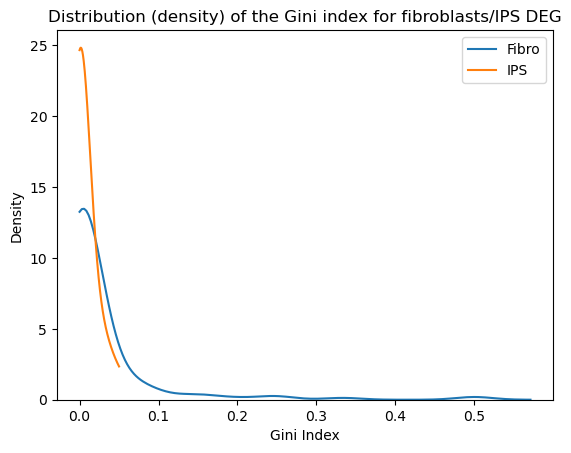

In [66]:
ax = sns.kdeplot(gini_plot_df["fibro"].dropna(), clip=(0,1), label="Fibro")#,  log_scale=True, alpha=1, palette=["r"]) #binwidth=0.01,
ax.set_title('Distribution (density) of the Gini index for fibroblasts/IPS DEG')
sns.kdeplot(gini_plot_df["ips"].dropna(), clip=(0,0.05), label="IPS")#,  log_scale=True, alpha=1, palette=["r"]) #binwidth=0.01,
ax.set_xlabel('Gini Index')
plt.legend()

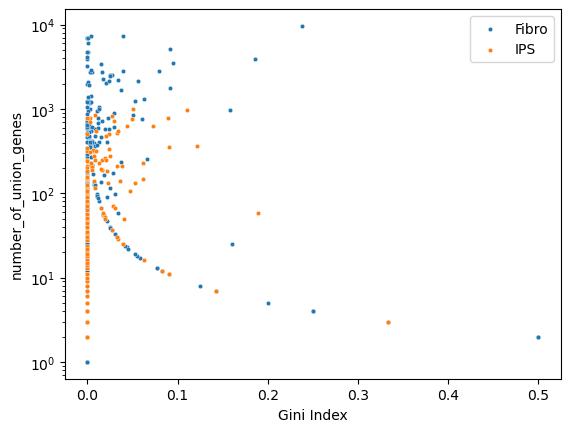

In [67]:
ax = sns.scatterplot(data=results_gini_df_fibro[0], x="gini_index", y="number_of_union_genes", s=10, label="Fibro")
ax = sns.scatterplot(data=results_gini_df_ips[0], x="gini_index", y="number_of_union_genes", s=10, label="IPS")
#ax.set_xlim(left=0, right=1)
ax.set(yscale="log")
ax.set_xlabel('Gini Index')
plt.legend()

In [135]:
results_gini_df_fibro

,gini_index,number_of_union_genes,aso_pairs
0,0.079493,2843.0,"(ASO_G0268895_01, ASO_G0268895_03)"
